# Socioeconomic correlations in purchasing patterns (Part 3)

In [1]:
import pandas as pd
import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker

def redshift_conn():
    config = {}
    config["redshift_user"] = "xxxxx"
    config["redshift_password"] = "xxxxx"
    config["redshift_host"] = "xxxxx"
    config["redshift_port"] = "xxxxx"
    config["redshift_database"] = "xxxxx"
    uri = 'redshift+psycopg2://{p[redshift_user]}:{p[redshift_password]}@{p[redshift_host]}:{p[redshift_port]}/{p[redshift_database]}'\
    .format(p=config)
    db_credentials = (uri)
    engine = sa.create_engine(db_credentials)
    Session = sessionmaker(bind=engine)
    return Session(), uri

conn, uri = redshift_conn()

/home/upadmin/anaconda3/envs/envpy27/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [68]:
query_test_create_table = """
select "column", type, encoding, distkey, sortkey, "notnull" 
from pg_table_def 
where tablename = 'transaction'
"""
pd.read_sql(query_test_create_table, conn.bind)

,column,type,encoding,distkey,sortkey,notnull
0,client_id,character varying(256),lzo,False,0,False
1,date,timestamp without time zone,bytedict,False,0,False
2,mcc,integer,lzo,False,0,False
3,mccg,integer,lzo,False,0,False
4,mccg_name,character varying(256),lzo,False,0,False
5,country_code,character varying(256),lzo,False,0,False
6,amount_sol,"numeric(18,0)",lzo,False,0,False
7,amount_usd,"numeric(18,0)",lzo,False,0,False
8,nb_transaction,integer,lzo,False,0,False
9,client_age,integer,delta,False,0,False


In [72]:
list_table_redshift = """
select distinct(tablename) 
from pg_table_def where schemaname = 'public';
"""
pd.read_sql(list_table_redshift, conn.bind)

,tablename
0,cell
1,mcc
2,movement
3,ref_cell
4,transaction
5,transaction_amp
6,transaction_puc


In [80]:
query_remove_table_pcg = """
DROP TABLE transaction_pcg;"""
try:
    pd.read_sql(query_remove_table_pcg, conn.bind)
except:
    print("Drop table transaction_pcg")

Drop table transaction_pcg


In [81]:
query_remove_table_temporal_pcg = """
DROP TABLE transaction_temporal_pcg;"""
try:
    pd.read_sql(query_remove_table_temporal_pcg, conn.bind)
except:
    print("Drop table transaction_temporal_pcg")

Drop table transaction_temporal_pcg


## Create purchase category group (PCG)


In [82]:
#Extract column date in format YYYYMM
query_create_table_temporal_pcg = """
CREATE TABLE transaction_temporal_pcg AS (
    SELECT t.client_id, t.mcc, t.mccg, t.amount_sol, p.class
    FROM (SELECT client_id, mcc, mccg, amount_sol
          FROM transaction
          WHERE amount_sol > 0.0
          AND mccg IN (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27)) t
    INNER JOIN
         (SELECT client_id, class
          FROM transaction_amp) p
    ON t.client_id = p.client_id
    ORDER BY t.client_id
)
"""
try:
    pd.read_sql(query_create_table_temporal_pcg, conn.bind)    
except:
    print("End execute query")

End execute query


# Validar la suma de gasto por mcc

In [74]:
select_table_pcg="""
SELECT t.mccg, sum(t.r_k_s)
FROM(    
    SELECT S.class, S.mccg, S.m_k_s, L.m_k, S.m_k_s/L.m_k as r_k_s 
    FROM (
        SELECT class, mccg, sum(amount_sol) as m_k_s
        FROM transaction_temporal_pcg
        WHERE amount_sol > 0.0
        AND mccg IN (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27)
        GROUP BY class, mccg
        ORDER BY class, mccg) S
            INNER JOIN (
                SELECT mccg, sum(amount_sol) as m_k
                FROM transaction
                WHERE amount_sol > 0.0
                AND mccg IN (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27)
                GROUP BY mccg
                ORDER BY mccg) L
            ON S.mccg = L.mccg
            ORDER BY S.class, S.mccg
    ) t
GROUP BY t.mccg
ORDER BY t.mccg
"""
pd.read_sql(select_table_pcg, conn.bind)

,mccg,sum
0,1,0.9985
1,2,0.9982
2,6,0.9990
3,7,0.9995
4,8,0.9992
5,9,0.9985
6,10,0.9991
7,11,0.9993
8,12,0.9990
9,13,0.9985


# Crear la tabla transaction_pcg

In [83]:
query_create_table_pcg = """
CREATE TABLE transaction_pcg AS (
    SELECT S.class, S.mccg, S.m_k_s, L.m_k, S.m_k_s/L.m_k as r_k_s 
    FROM (
        SELECT class, mccg, sum(amount_sol) as m_k_s
        FROM transaction_temporal_pcg
        WHERE amount_sol > 0.0
        AND mccg IN (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27)
        GROUP BY class, mccg
        ORDER BY class, mccg) S
            INNER JOIN (
                SELECT mccg, sum(amount_sol) as m_k
                FROM transaction
                WHERE amount_sol > 0.0
                AND mccg IN (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27)
                GROUP BY mccg
                ORDER BY mccg) L
            ON S.mccg = L.mccg
            ORDER BY S.class, S.mccg
    )
"""
try:
    pd.read_sql(query_create_table_pcg, conn.bind)
except:
    print("End execute query")

End execute query


In [85]:
query_select_ = """
SELECT *
FROM transaction_pcg
"""
df_r_k_s = pd.read_sql(query_select_, conn.bind)

In [92]:
mccg_names = []

for row in df_r_k_s['mccg']:
    if row == 1:
        mccg_names.append('Airlines')
    elif row == 2:
        mccg_names.append('Amusement and Entertainment')
    elif row == 3:
        mccg_names.append('Associations')
    elif row == 4:
        mccg_names.append('Vehicle Rentals')
    elif row == 5:
        mccg_names.append('Automobiles and Vehicles')
    elif row == 6:
        mccg_names.append('Business Services')
    elif row == 7:
        mccg_names.append('Cleaning Preparations')
    elif row == 8:
        mccg_names.append('Clothing Stores')
    elif row == 9:
        mccg_names.append('Contracted Services')
    elif row == 10:
        mccg_names.append('Education')
    elif row == 11:
        mccg_names.append('Gas Stations')
    elif row == 12:
        mccg_names.append('Government Services')
    elif row == 13:
        mccg_names.append('Hotels and Motels')
    elif row == 14:
        mccg_names.append('Mail Phone Order')
    elif row == 15:
        mccg_names.append('Miscellaneous Stores')
    elif row == 16:
        mccg_names.append('Personal Services')
    elif row == 17:
        mccg_names.append('Professional Services')
    elif row == 18:
        mccg_names.append('High Risk Personal Retail')
    elif row == 19:
        mccg_names.append('High Risk Personal Services')
    elif row == 20:
        mccg_names.append('Publishing Services')
    elif row == 21:
        mccg_names.append('Repair Services')
    elif row == 22:
        mccg_names.append('Restaurants')
    elif row == 23:
        mccg_names.append('Retail Stores')
    elif row == 24:
        mccg_names.append('Service Providers')
    elif row == 25:
        mccg_names.append('Telecom and Data Utilities')
    elif row == 26:
        mccg_names.append('Transportation')
    elif row == 27:
        mccg_names.append('Utilities')
    elif row == 28:
        mccg_names.append('Wholesale Trade')
    else:
        mccg_names.append('Failed')
        
df_r_k_s["mccg_name"] = mccg_names

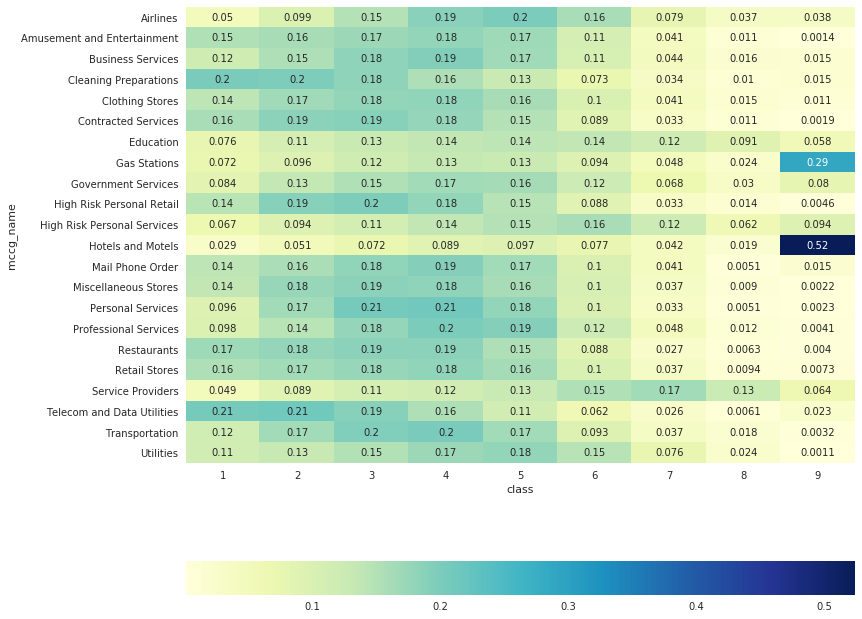

In [94]:
%matplotlib inline
import numpy as np
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,12))


df_transaction = df_r_k_s.pivot("mccg_name", "class", "r_k_s")

ax = sns.heatmap(df_transaction, cmap="YlGnBu",                 
                 ax=ax, annot=True,
                 cbar_kws={"orientation": "horizontal"})

In [93]:
df_r_k_s

,class,mccg,m_k_s,m_k,r_k_s,mccg_name
0,1,2,20698897.0,1.342609e+08,0.1541,Amusement and Entertainment
1,1,7,15923058.0,7.863471e+07,0.2024,Cleaning Preparations
2,1,8,173826150.0,1.235498e+09,0.1406,Clothing Stores
3,1,11,53706148.0,7.456482e+08,0.0720,Gas Stations
4,1,13,12363540.0,4.285817e+08,0.0288,Hotels and Motels
5,1,14,3573318.0,2.536638e+07,0.1408,Mail Phone Order
6,1,17,43619395.0,4.446262e+08,0.0981,Professional Services
7,1,18,135657710.0,9.388036e+08,0.1445,High Risk Personal Retail
8,1,23,172578305.0,1.108236e+09,0.1557,Retail Stores
9,1,25,28155588.0,1.356351e+08,0.2075,Telecom and Data Utilities
